<a href="https://colab.research.google.com/github/peeyushsinghal/ERA/blob/main/S7/ERA_S7_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective / Target
**Objective / Target**
* Increase accuracy by increasing capacity
* Play with LR

**Results**

* Parameters: 7,900
* Best Train Accuracy: 98.91
* Best Test Accuracy: 99.31

**Analysis**

* Not Able to hit the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 8K
* Adding params near output helped much, so did removing input

**Next Steps**

* Play with large LR


# Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


# Data Transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train / Test Split

In [4]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

## Data Loader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Checking Dataloader

torch.Size([128, 1, 28, 28])
torch.Size([128])


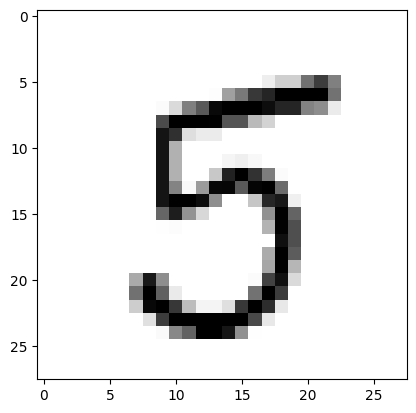

In [6]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

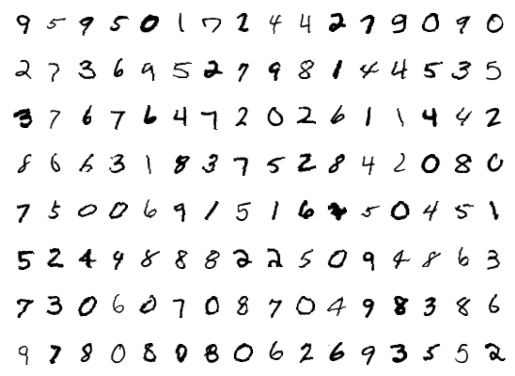

In [7]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Model

In [8]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method

    drop_out_value = 0.1

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,12,3 , bias= False ), # In- 1x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(12),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(12,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(16,12,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(12),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Transition Block 1 (this also includes a conv block)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(32,16,1), # In- 32x12x12, Out- 16x12x12, RF- 8x8, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(16),
    #     nn.Dropout(drop_out_value)
    # )

    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(12,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x9x9, Out- 16x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    )

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16,10,1, bias= False ), # In- 16x7x7, Out- 10x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        # nn.ReLU()
        # ,
        # nn.BatchNorm2d(10, affine=True),
        # nn.Dropout(drop_out_value)
    )

    self.gap = nn.AvgPool2d(7) # In- 10x7x7, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2


  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)

    x = self.pool1(x)
    # x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)

    x = self.convblock7(x)

    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

## Model Params

In [9]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,728
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

# Training and Testing

## Training

In [10]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy.append(100*correct/processed)


## Test

In [11]:
# Test Function
test_losses = [] # to capture test losses
test_accuracy = [] # to capture test accuracy

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))
  return float("{:.4f}".format(np.average(avg_epoch_test_loss)))


## Execution

In [12]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [18]:
model =  Network().to(device)
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# LR_GAMMA = 0.5
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR
# scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 1, threshold =  0.0002, verbose = True)
# scheduler = ExponentialLR (optimizer, gamma =0.3)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    curr_lr = optimizer.param_groups[0]['lr']
    # print(f'current learning rate :', curr_lr)
    val_loss = test(model, device, test_loader)
    # print(f'current learning rate :{curr_lr} and val_loss is {val_loss}')
    scheduler.step(val_loss)
    # if epoch > 5:
    #   optimizer = optim.SGD(model.parameters(), lr=curr_lr*LR_GAMMA, momentum=0.9)




EPOCH: 1 Current LR :  0.4


Loss=0.07932595163583755 Batch_id=468 Accuracy=92.79%: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]



Test set: Average loss: 0.000089, Accuracy: 9840/10000 (98.40%)

EPOCH: 2 Current LR :  0.4


Loss=0.08420247584581375 Batch_id=468 Accuracy=97.50%: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.000013, Accuracy: 9840/10000 (98.40%)

EPOCH: 3 Current LR :  0.4


Loss=0.07566431164741516 Batch_id=468 Accuracy=97.72%: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.000001, Accuracy: 9869/10000 (98.69%)

EPOCH: 4 Current LR :  0.4


Loss=0.024493472650647163 Batch_id=468 Accuracy=98.17%: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]



Test set: Average loss: 0.000054, Accuracy: 9907/10000 (99.07%)

Epoch 00004: reducing learning rate of group 0 to 4.0000e-02.
EPOCH: 5 Current LR :  0.04000000000000001


Loss=0.03060012497007847 Batch_id=468 Accuracy=98.65%: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]



Test set: Average loss: 0.000001, Accuracy: 9924/10000 (99.24%)

EPOCH: 6 Current LR :  0.04000000000000001


Loss=0.020898394286632538 Batch_id=468 Accuracy=98.83%: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]



Test set: Average loss: 0.000023, Accuracy: 9931/10000 (99.31%)

Epoch 00006: reducing learning rate of group 0 to 4.0000e-03.
EPOCH: 7 Current LR :  0.004000000000000001


Loss=0.003259005257859826 Batch_id=468 Accuracy=98.83%: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]



Test set: Average loss: 0.000006, Accuracy: 9928/10000 (99.28%)

EPOCH: 8 Current LR :  0.004000000000000001


Loss=0.012757908552885056 Batch_id=468 Accuracy=98.82%: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]



Test set: Average loss: 0.000005, Accuracy: 9927/10000 (99.27%)

Epoch 00008: reducing learning rate of group 0 to 4.0000e-04.
EPOCH: 9 Current LR :  0.00040000000000000013


Loss=0.05201311409473419 Batch_id=468 Accuracy=98.89%: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.000002, Accuracy: 9929/10000 (99.29%)

EPOCH: 10 Current LR :  0.00040000000000000013


Loss=0.03750240430235863 Batch_id=468 Accuracy=98.87%: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]



Test set: Average loss: 0.000175, Accuracy: 9928/10000 (99.28%)

Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
EPOCH: 11 Current LR :  4.000000000000002e-05


Loss=0.010560507886111736 Batch_id=468 Accuracy=98.87%: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]



Test set: Average loss: 0.000003, Accuracy: 9926/10000 (99.26%)

EPOCH: 12 Current LR :  4.000000000000002e-05


Loss=0.006010118406265974 Batch_id=468 Accuracy=98.84%: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]



Test set: Average loss: 0.000000, Accuracy: 9928/10000 (99.28%)

Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
EPOCH: 13 Current LR :  4.0000000000000015e-06


Loss=0.037219781428575516 Batch_id=468 Accuracy=98.89%: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.000018, Accuracy: 9926/10000 (99.26%)

EPOCH: 14 Current LR :  4.0000000000000015e-06


Loss=0.0059025585651397705 Batch_id=468 Accuracy=98.85%: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.000001, Accuracy: 9927/10000 (99.27%)

Epoch 00014: reducing learning rate of group 0 to 4.0000e-07.
EPOCH: 15 Current LR :  4.000000000000002e-07


Loss=0.06922272592782974 Batch_id=468 Accuracy=98.91%: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.000000, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

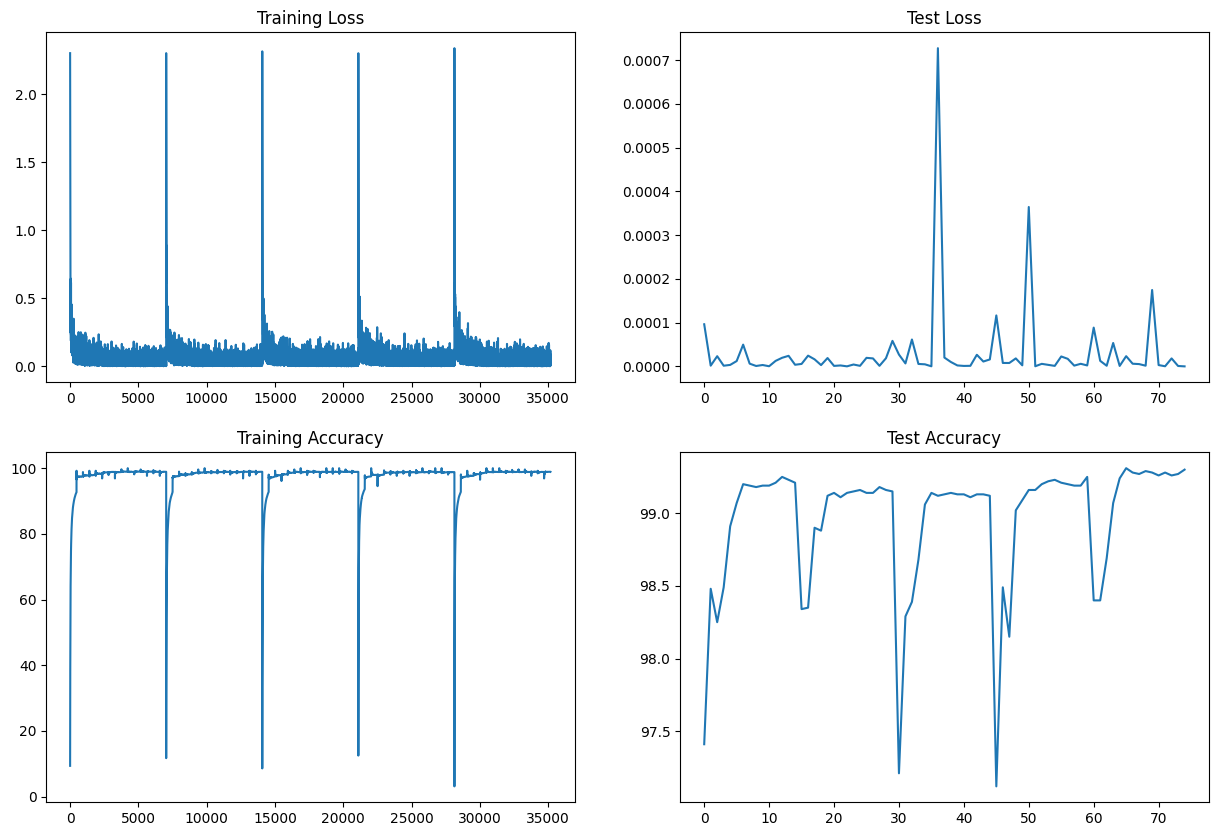

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")